In [2]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

sns.set_style('whitegrid')

Trying to estimate the mixture of Dirichilet distirbution because of 4 missing data points out of total 40 samples. We can see, using the conditional of the first 36 complete samples as a prior to estimate the full postieror, the estimation error on tail probability is quite large.
- prior: $p(\theta|y_{1:36}) \thicksim Dir(a=[44.2, 1.7, 0.1])$
- full posterior: $p(\theta|y_{1:40})$

In [16]:
# two unnormalized likelihood for the target and proposal
def dirichlet_logg(theta, a):
    return (a-1) @ np.log(theta)

def dirichlet_logp(theta, a):
    logp = dirichlet_logg(theta, a)
    logp += 4 * np.log(theta[1] + theta[2])
    return logp

alpha = 10
m = np.array([0.92, 0.07, 0.01])
samples = np.array([35, 1, 0])

# proposal uses the first 36 data points
a = alpha*m + np.array([35, 1, 0])
θs = np.random.dirichlet(a, size=100000)

iws = []
for theta in θs:
    logg = dirichlet_logg(theta, a)
    logp = dirichlet_logp(theta, a)
    logw = logp - logg
    iws.append((logp, logg, logw))

iws = pd.DataFrame(iws, columns=['logp','logg','logw'])
ws = np.exp(iws.logw - iws.logw.max())
ws /= ws.sum()
iws['ws'] = ws

4804.061746791002 0.048040617467910024


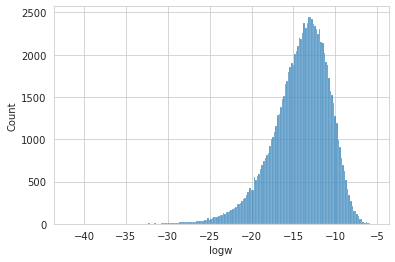

In [17]:
sns.histplot(iws.logw)
# ESS
print(1/(iws.ws@iws.ws), 1/(iws.ws@iws.ws)/100000)

In [18]:
(iws.ws.values.reshape(-1, 1) * θs).sum(0)

array([0.88355854, 0.10990884, 0.00653262])

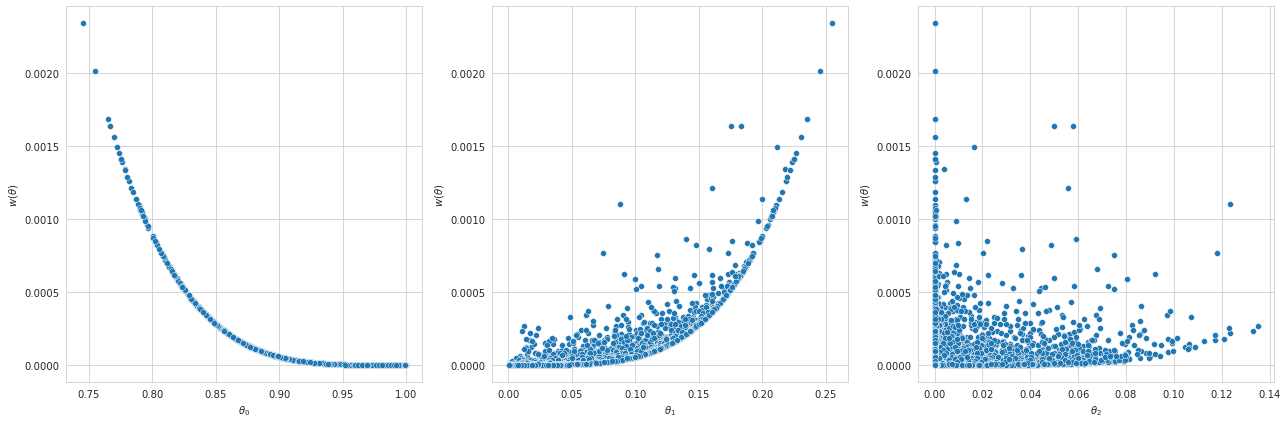

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

for i in range(3):
    sns.scatterplot(x=θs[:,i], y=iws.ws, ax=ax[i])
    ax[i].set_xlabel(f'$\\theta_{i}$')
    ax[i].set_ylabel(f'$w(\\theta)$')

fig.tight_layout()
fig.show()